In [37]:
import os
import re
import timeit
import string
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer

In [10]:
no_real_disater = 0
real_disaster = 1

no_real_disaster_label = "no_real_disaster"
real_disaster_label = "real_disaster"

target_names = ["Not real disaster", "Real disaster"]

target_dict = {
    "label": target_names,
    "value": [0, 1]
}
target_df = pd.DataFrame(target_dict)

original_columns = ["id", "keyword", "location", "text", "target"]

stop_words = stopwords.words('english')

### Data folders

In [11]:
data_folder = "data"
submissions_folder = os.path.join(data_folder, "submissions") 

train_file = os.path.join(data_folder, "train.csv")
test_file = os.path.join(data_folder, "test.csv")

### Data analysis

In [12]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)


# Adding target labels
train_df.loc[:, "target_str"] = pd.merge(train_df, target_df, how="left", left_on="target", right_on="value")["label"]

train_df.head()

,id,keyword,location,text,target,target_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


In [13]:
print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (7613, 6)
Test size: (3263, 4)


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   target_str  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


#### Convert to string type

In [15]:
string_columns = ["keyword", "location", "text", "target_str"]
train_df.loc[:, string_columns] = train_df[string_columns].astype("string")

In [16]:
train_df.head()

,id,keyword,location,text,target,target_str
0,1,<NA>,<NA>,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,<NA>,<NA>,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,<NA>,<NA>,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,<NA>,<NA>,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,<NA>,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


#### NaNs vs NO NaNs by column

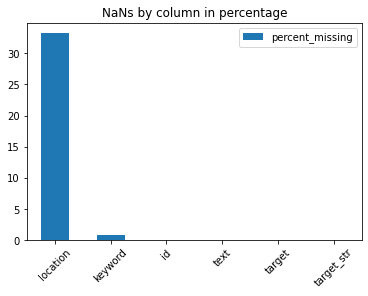

In [17]:
percent_missing = train_df.isnull().sum() * 100 / train_df.shape[0]
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})

missing_value_df.sort_values(by="percent_missing", ascending=False).plot(
    kind="bar", title="NaNs by column in percentage", rot=45)

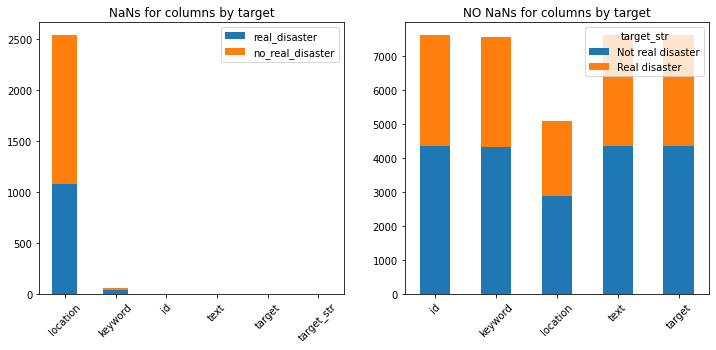

In [18]:
no_nan_df = train_df.groupby("target_str").count().transpose()

cond_disaster = train_df.target == real_disaster
nan_df = pd.concat([train_df[cond_disaster].isnull().sum(),
                    train_df[~cond_disaster].isnull().sum()], axis=1)
nan_df.columns = [real_disaster_label, no_real_disaster_label]
nan_df.sort_values(by=[real_disaster_label], ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 5))

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

nan_df.plot(kind="bar", stacked=True, title="NaNs for columns by target", ax=ax1, rot=45)
no_nan_df.plot(kind="bar", stacked=True, title="NO NaNs for columns by target", ax=ax2, rot=45)

#### Keyword

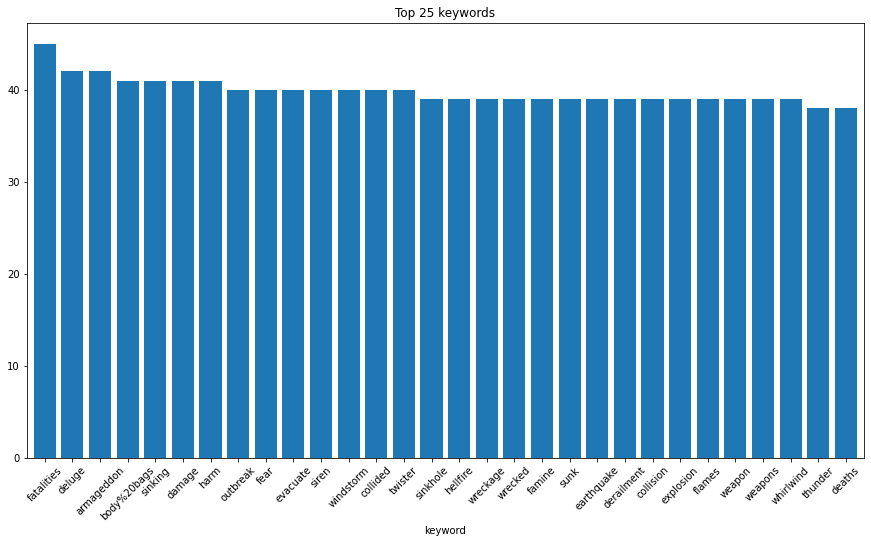

In [19]:
train_df.groupby("keyword").size().sort_values(ascending=False)[:30].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 keywords", rot=45)

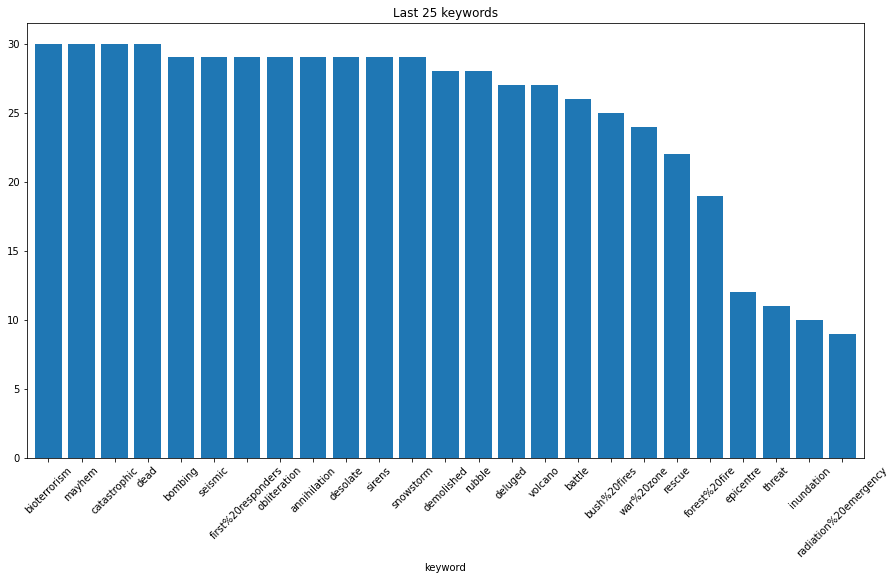

In [20]:
train_df.groupby("keyword").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 keywords", rot=45)

#### Location

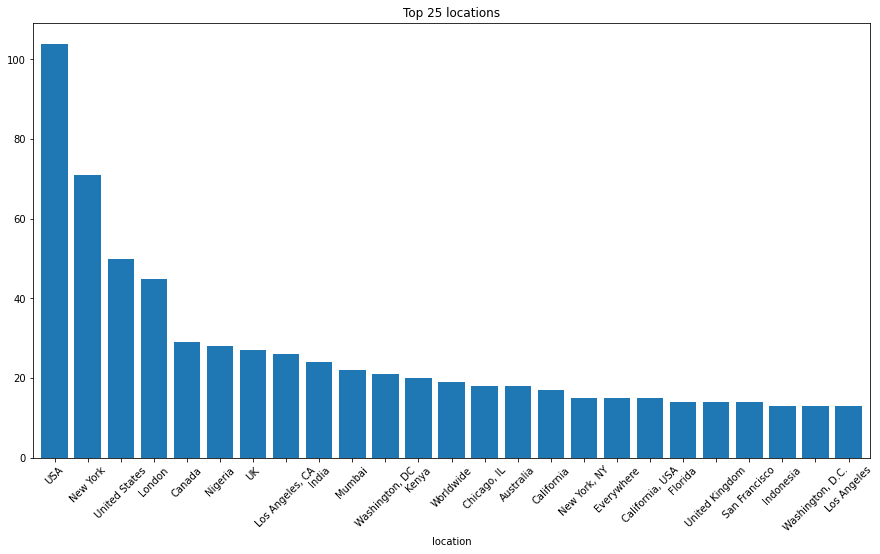

In [21]:
train_df.groupby("location").size().sort_values(ascending=False)[:25].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 locations", rot=45)

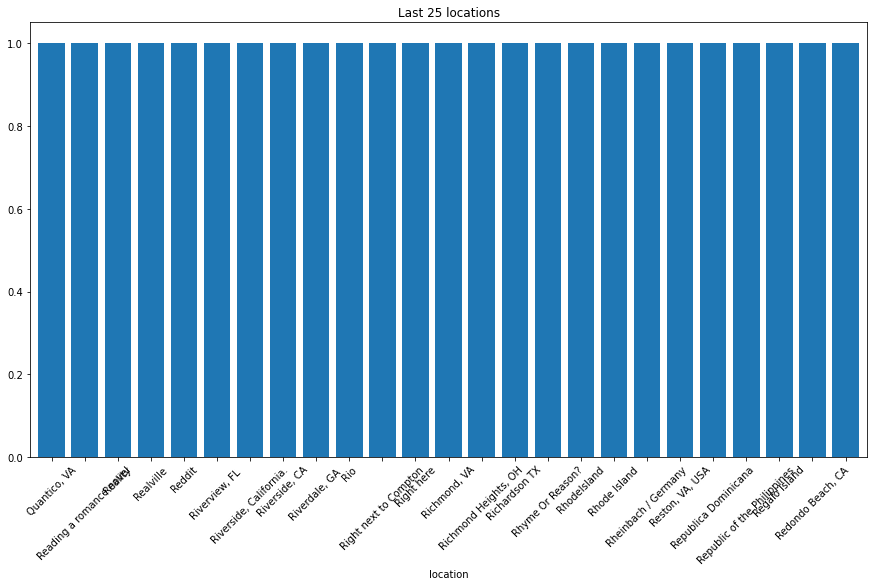

In [22]:
train_df.groupby("location").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 locations", rot=45)

#### Target

(-1.25, 1.25, -1.25, 1.25)

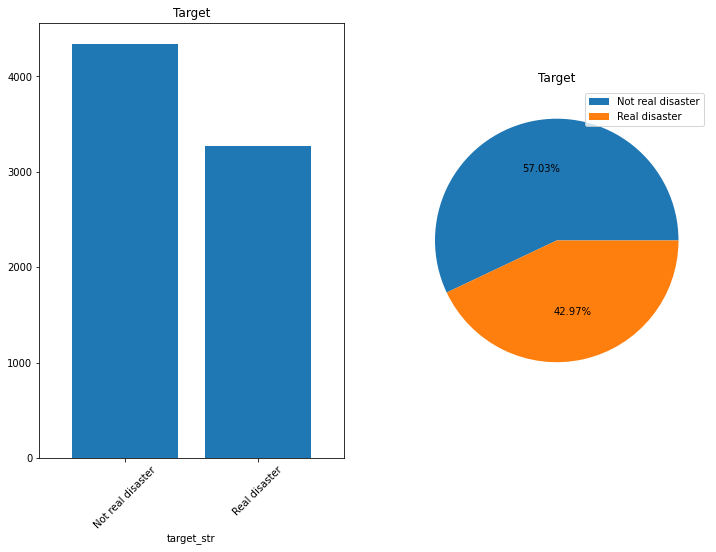

In [23]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, legend=True, autopct="%.2f%%", labels=None)

ax2.axis("off")

### Text

Choose randomly 5 tweets for visualize text content

In [24]:
for tweet, keyword, label in train_df[["text", "keyword", "target_str"]].sample(n=5).values:
    print(f"{keyword}\n{tweet}\n{label}\n")

suicide%20bomber
Suicide Bomber Kills 13 At Saudi Mosque http://t.co/oZ1DS3Xu0D #Saudi #Tripoli #Libya
Real disaster

obliterated
We destroyed the #Zimmerman fan club on Twitter @rzimmermanjr and we obliterated Renewsit reduced her to a sock acc. http://t.co/ybshleIE3p
Not real disaster

obliteration
There are no four truths-of pain of desire that is the origin of pain of the obliteration of that desire of the pain to that obliteration.
Not real disaster

suicide%20bomber
http://t.co/9k1tqsAarM Suicide bomber kills 15 in Saudi security site mosque - Reuters http://t.co/Ev3nX9scx3
Real disaster

destroyed
@justicemalala @nkeajresq Nkea destroyed lives in Gambia as a mercenary judge.
Not real disaster



In [25]:
# Adding new feature: text_lenght
train_df.loc[:, "text_lenght"] = train_df.text.str.len()

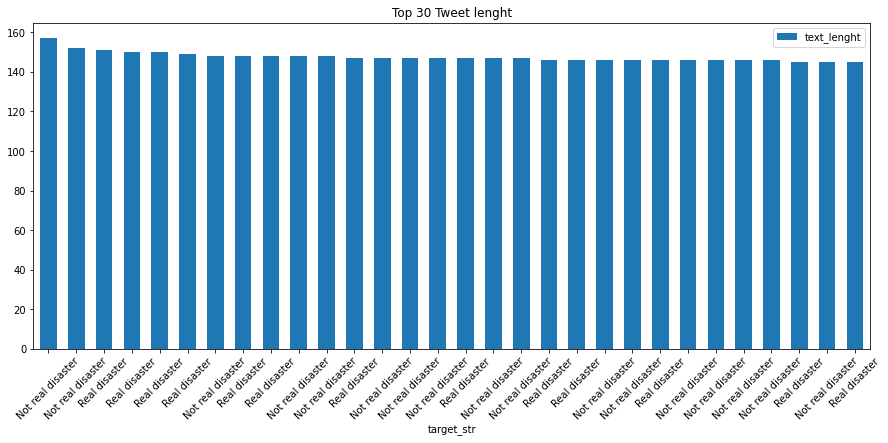

In [26]:
top_len_df = train_df[["text_lenght", "target", "target_str"]].sort_values(
    by="text_lenght", ascending=False).head(30).reset_index(drop=True)
last_len_df = train_df[["text_lenght", "target", "target_str"]].sort_values(
    by="text_lenght", ascending=False).tail(30).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 6))
top_len_df.plot(kind="bar", y="text_lenght", x="target_str", width=0.6, 
                ax=ax, title="Top 30 Tweet lenght", rot=45)

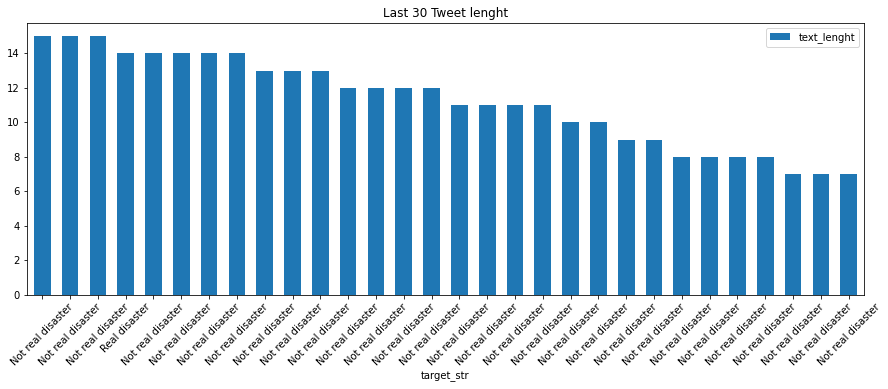

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
last_len_df.plot(kind="bar", y="text_lenght", x="target_str", width=0.6, 
                ax=ax, title="Last 30 Tweet lenght", rot=45)

In [28]:
def generate_word_frequences_dict(text_list, stop_words):
    # Filter stop words and remove puntuation
    word_list = [word for text in text_list for word in text if word.isalpha() and word not in stop_words]
    return pd.Series(word_list).value_counts().to_dict()

def generate_word_cloud(text_list, title, stop_words=stop_words):
    frequences_dict = generate_word_frequences_dict(text_list, stop_words)
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

In [29]:
def split_text(text, stop_words):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    
    return words

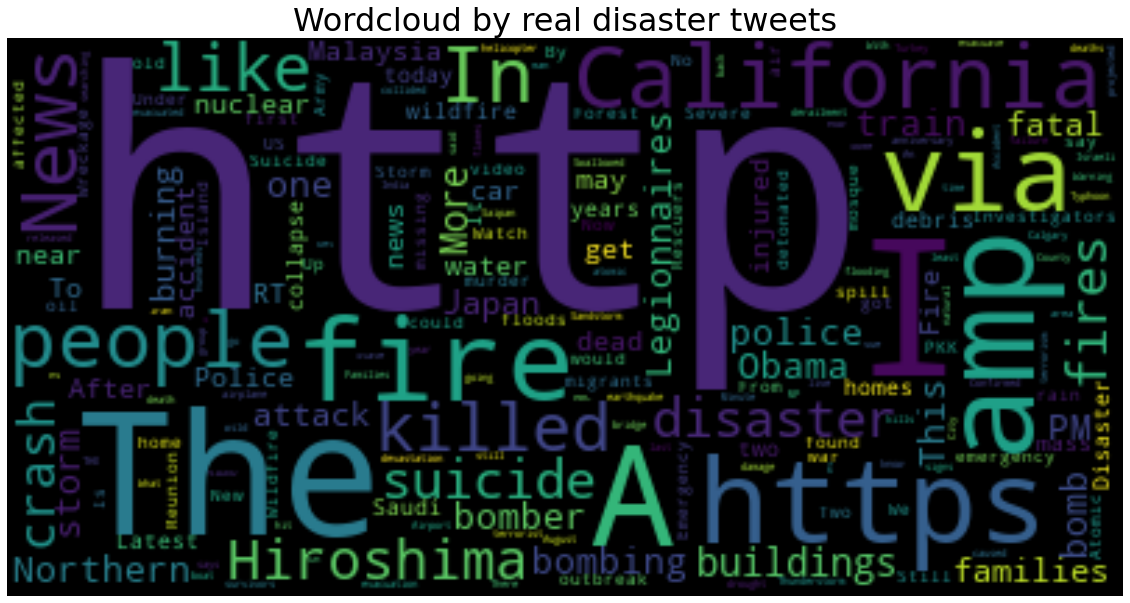

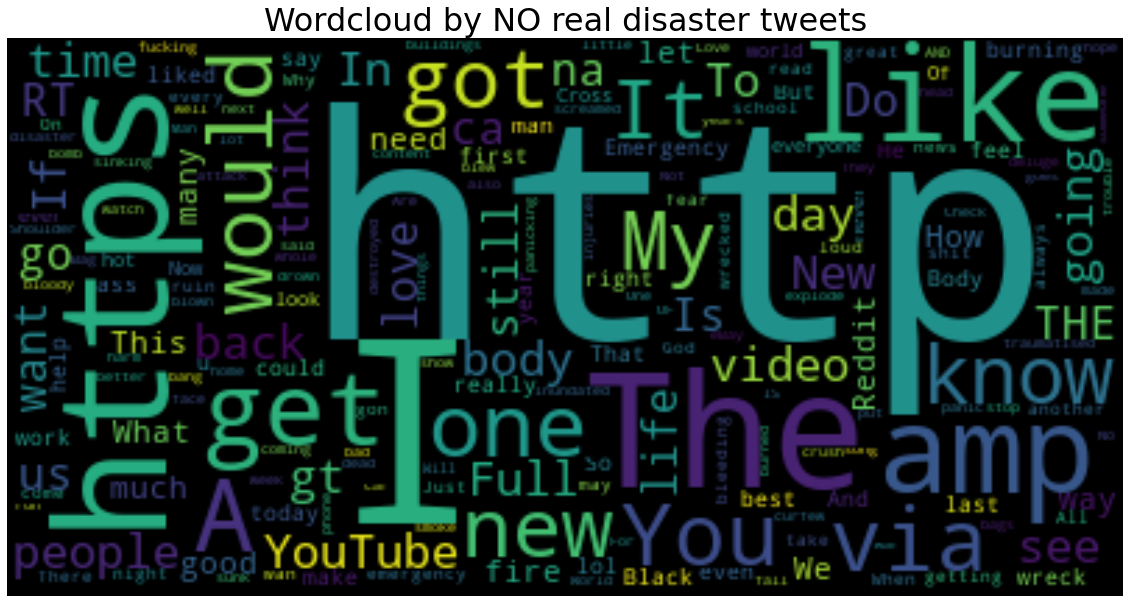

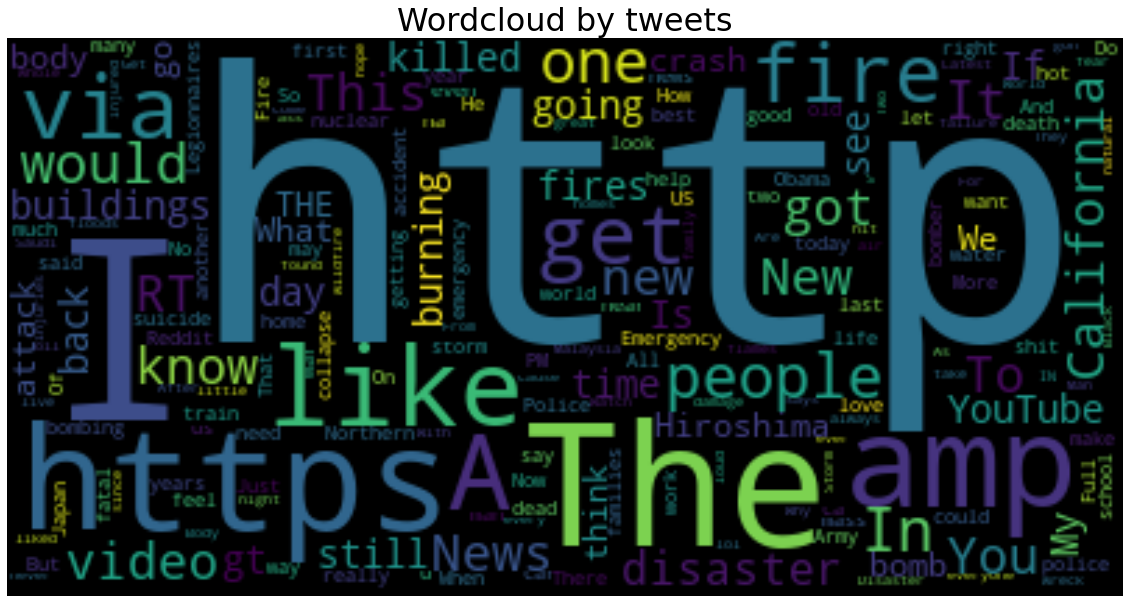

In [30]:
train_df.loc[:, "splited_text"] = train_df["text"].apply(split_text, args=(stop_words,))

generate_word_cloud(train_df[cond_disaster]["splited_text"].values.tolist(), "Wordcloud by real disaster tweets")
generate_word_cloud(train_df[~cond_disaster]["splited_text"].values.tolist(), "Wordcloud by NO real disaster tweets")
generate_word_cloud(train_df["splited_text"].values.tolist(), "Wordcloud by tweets")

### Data cleaning and feature engineering

Remove id column because is not useful

In [31]:
train_df.drop("id", axis=1, inplace=True)

In [32]:
train_df.head()

,keyword,location,text,target,target_str,text_lenght,splited_text
0,<NA>,<NA>,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,"[Our, Deeds, Reason, earthquake, May, ALLAH, F..."
1,<NA>,<NA>,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,<NA>,<NA>,All residents asked to 'shelter in place' are ...,1,Real disaster,133,"[All, residents, asked, place, notified, offic..."
3,<NA>,<NA>,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,"[people, receive, wildfires, evacuation, order..."
4,<NA>,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,"[Just, got, sent, photo, Ruby, Alaska, smoke, ..."


Replace NaN values from keyword and location columns by empty string ("")

In [33]:
train_df.loc[:, ["keyword", "location"]] = train_df[["keyword", "location"]].fillna("")

Create new features based on keyword and location (and previous text_lenght).

In [34]:
train_df.loc[:, "with_keyword"] = train_df.keyword.str.len().astype(bool)
train_df.loc[:, "with_location"] = train_df.location.str.len().astype(bool)

train_df.head()

,keyword,location,text,target,target_str,text_lenght,splited_text,with_keyword,with_location
0,,,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,"[Our, Deeds, Reason, earthquake, May, ALLAH, F...",False,False
1,,,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,"[Forest, fire, near, La, Ronge, Sask, Canada]",False,False
2,,,All residents asked to 'shelter in place' are ...,1,Real disaster,133,"[All, residents, asked, place, notified, offic...",False,False
3,,,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,"[people, receive, wildfires, evacuation, order...",False,False
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,"[Just, got, sent, photo, Ruby, Alaska, smoke, ...",False,False


### Clean tweets content

- Remove puntuation
- Filter stop words
- Stemming

NLTK data url: https://github.com/nltk/nltk_data

Convert tweets to sentences

In [51]:
stop_words = stopwords.words('english')

def clean_html (sentence):
    cleaned_text = re.sub(r'http\S+', r'', sentence)
    return cleaned_text

porter = PorterStemmer()
def text_cleaning(text, stop_words=stop_words):
    text = clean_html(text)
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmed = [porter.stem(word) for word in words]
    
    return stemmed

wn = WordNetLemmatizer()
def text_cleaning_v2(text, stop_words=stop_words):
    text = clean_html(text)
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    # Lammitization
    lemmatize = [wn.lemmatize(word) for word in words]
    
    return lemmatize


def html_cleaning(text):
    # Clean html encoding
    text = BeautifulSoup(text, 'lxml').get_text()
    return text

mentions_reg = re.compile(r'@[A-Za-z0-9]+')
links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
def text_cleaning_v3(text, stop_words=stop_words):
    text = html_cleaning(text)

    # Remove mentions
    text = re.sub(mentions_reg, "", text)

    # Remove url
    text = re.sub(links_reg, "", text)

    # Split text into tokens
    tokens = word_tokenize(text)

    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]

    # Filter stop words
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmed = [porter.stem(word) for word in words]

    return stemmed

def text_cleaning_v4(text, stop_words=stop_words):
    text = html_cleaning(text)

    # Remove mentions
    text = re.sub(mentions_reg, "", text)

    # Remove url
    text = re.sub(links_reg, "", text)

    # Split text into tokens
    tokens = word_tokenize(text)

    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]

    # Filter stop words
    words = [word for word in words if word not in stop_words]

    # Stemming
    lemmatize = [wn.lemmatize(word) for word in words]

    return lemmatize

In [39]:
train_df.loc[:, "splitted_cleaned_text"] = train_df["text"].apply(text_cleaning_v3, args=(stop_words,))

Choose randomly 5 tweets for visualize text and list of cleaned words

In [40]:
for tweet, cleaned, label in train_df[["text", "splitted_cleaned_text", "target_str"]].sample(n=5).values:
    print(f"{tweet}\n{cleaned}\n{label}\n")

'Choose to be happy. Fire truck the rest.' http://t.co/tAmRCWfYgd ????? Review of Kick Push by @JayMcLeanAuthor
['happi', 'fire', 'truck', 'rest', 'review', 'kick', 'push']
Not real disaster

Colorado movie massacre trial jurors reach verdict on mitigating factors http://t.co/75VLsw85GI http://t.co/txY3US2Ejs
['colorado', 'movi', 'massacr', 'trial', 'juror', 'reach', 'verdict', 'mitig', 'factor']
Real disaster

@danisnotonfire if you follow me I will go into town and advertise your youtube channel by screaming and walking around with a sign. Pls??
['follow', 'I', 'go', 'town', 'advertis', 'youtub', 'channel', 'scream', 'walk', 'around', 'sign', 'pl']
Not real disaster

Reddit Will Now Quarantine OffensiveåÊContent https://t.co/MjbIUvbMo6 http://t.co/I5cdTD8ftj
['reddit', 'will', 'now', 'quarantin', 'offensiveåêcont']
Not real disaster

Driver rams car into Israeli soldiers wounds 3: military: A driver rammed a car into a group of Israeli soldi... http://t.co/oBSZ45ybAJ
['driver', 'ram'

In [41]:
train_df.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: string

In [ ]:
# TODO: millorar la manera de netejar el text

#### Clean text data

In [54]:
tweet = 'Our Deeds are the Reason! of this #earthquake May ALLAH Forgive us all. http://www.google.com'

Tokenitzation

In [65]:
print(word_tokenize(tweet))

['Our', 'Deeds', 'are', 'the', 'Reason', '!', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all', '.', 'http', ':', '//www.google.com']


Remove puntuations

In [66]:
print([t for t in tokens if t.isalpha()])

['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all', 'http']


Filter stop words

In [67]:
print([word for word in words if word not in stop_words])

['Our', 'Deeds', 'Reason', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'http']


Stemming

In [68]:
porter = PorterStemmer()
print([porter.stem(word) for word in words])

['our', 'deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us', 'http']


Lammitization

In [69]:
print([wn.lemmatize(word) for word in words])

['Our', 'Deeds', 'Reason', 'earthquake', 'May', 'ALLAH', 'Forgive', 'u', 'http']


In [81]:
def clean_html (sentence):
    cleantext = re.sub(r'http\S+', r'', sentence)
    return cleantext

In [84]:
cleanhtml(tweet)

'Our Deeds are the Reason! of this #earthquake May ALLAH Forgive us all. '

### Vectoritzation I: Count vectorizer

In [108]:
example_sentences = [
    'He is playing in the field field',
    'He is running towards the football',
    'The football game ended',
    'It started raining while everyone was playing in the field'
]

words = list()
for sentence in example_sentences:
    for word in sentence.split(" "):
        words.append(word)
        
word_number = collections.Counter(words)

print(f"Top 5 words: {word_number.most_common(5)}")

Top 5 words: [('the', 3), ('field', 3), ('He', 2), ('is', 2), ('playing', 2)]


In [109]:
vectorizer = CountVectorizer()
sentence_vectors = vectorizer.fit_transform(example_sentences)

print(f"All vocabulary: {vectorizer.get_feature_names()}")

All vocabulary: ['ended', 'everyone', 'field', 'football', 'game', 'he', 'in', 'is', 'it', 'playing', 'raining', 'running', 'started', 'the', 'towards', 'was', 'while']


In [110]:
count_vectorized_df = pd.DataFrame(sentence_vectors.toarray(), columns=vectorizer.get_feature_names())
count_vectorized_df

,ended,everyone,field,football,game,he,in,is,it,playing,raining,running,started,the,towards,was,while
0,0,0,2,0,0,1,1,1,0,1,0,0,0,1,0,0,0
1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0
2,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1


Vectoritzation of first sentence

In [111]:
non_zero_columns = count_vectorized_df.head(1)[count_vectorized_df > 0].dropna(axis=1).columns.tolist()
print(f"For sentenence 1 this columns {non_zero_columns} are greather than 0 (full sentence)")
print(example_sentences[0])
count_vectorized_df.head(1)

For sentenence 1 this columns ['field', 'he', 'in', 'is', 'playing', 'the'] are greather than 0 (full sentence)
He is playing in the field field


,ended,everyone,field,football,game,he,in,is,it,playing,raining,running,started,the,towards,was,while
0,0,0,2,0,0,1,1,1,0,1,0,0,0,1,0,0,0


In [112]:
count_vectorized_df.sum().sort_values(ascending=False)

the         4
field       3
in          2
football    2
playing     2
he          2
is          2
while       1
everyone    1
game        1
it          1
was         1
raining     1
running     1
started     1
towards     1
ended       1
dtype: int64

In [35]:
word_number.most_common(5)

[('the', 3), ('field', 3), ('He', 2), ('is', 2), ('playing', 2)]

Same order

### Vectoritzation II: TF-IDF Vectorizer (equivalent to CountVectorizer followed by TfidfTransformer)

<b>TF (Term Frequency):</b> It is defined as the number of times a word appears in the given sentence.<br>
<b>IDF (Inverse Document Frequency):</b> It is defined as the log to the base e of number of the total documents divided by the documents in which the word appears.

In [36]:
vectorizer = TfidfVectorizer()
sentence_vectors = vectorizer.fit_transform(example_sentences)

print(f"All vocabulary {vectorizer.get_feature_names()}")

All vocabulary ['ended', 'everyone', 'field', 'football', 'game', 'he', 'in', 'is', 'it', 'playing', 'raining', 'running', 'started', 'the', 'towards', 'was', 'while']


In [37]:
tf_idf_vectorized_df = pd.DataFrame(sentence_vectors.toarray(), columns=vectorizer.get_feature_names())
tf_idf_vectorized_df

,ended,everyone,field,football,game,he,in,is,it,playing,raining,running,started,the,towards,was,while
0,0.000000,0.000000,0.688506,0.000000,0.000000,0.344253,0.344253,0.344253,0.000000,0.344253,0.000000,0.000000,0.000000,0.227858,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.387619,0.000000,0.387619,0.000000,0.387619,0.000000,0.000000,0.000000,0.491646,0.000000,0.256561,0.491646,0.000000,0.000000
2,0.587838,0.000000,0.000000,0.463458,0.587838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.306758,0.000000,0.000000,0.000000
3,0.000000,0.350562,0.276387,0.000000,0.000000,0.000000,0.276387,0.000000,0.350562,0.276387,0.350562,0.000000,0.350562,0.182938,0.000000,0.350562,0.350562


Find words weight

In [38]:
tf_idf_vectorized_df.sum().sort_values(ascending=False)

the         0.974115
field       0.964893
football    0.851077
is          0.731872
he          0.731872
playing     0.620640
in          0.620640
ended       0.587838
game        0.587838
towards     0.491646
running     0.491646
everyone    0.350562
while       0.350562
was         0.350562
raining     0.350562
started     0.350562
it          0.350562
dtype: float64

In [39]:
word_number.most_common(5)

[('the', 3), ('field', 3), ('He', 2), ('is', 2), ('playing', 2)]

In this case we can see the difference, the word "field" appears 2 times on sentence one and one time on sentence two, but have 
the same weight of "in", but "in" appears 2 times on 2 different sentences.

### Vectoritzation III: Hashing vectorizer

In [40]:
vectorizer = HashingVectorizer(norm=None, n_features=5)
sentence_vectors = vectorizer.fit_transform(example_sentences)

print(sentence_vectors.toarray())

[[-2.  0.  2. -1.  2.]
 [ 0. -1.  3. -1.  1.]
 [ 0. -1.  1. -2.  0.]
 [-3.  1.  1.  0. -1.]]


### Model Validation

Try different experiments to evaluate different models

In [52]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.20, random_state=90)

In [53]:
def train_and_predict_pipeline(pipeline, x_train, y_train, x_test, y_test, target_names):
    print("\nTraining model ...")
    
    start = timeit.default_timer()
    pipeline.fit(x_train, y_train)
    stop = timeit.default_timer()
    
    training_time = stop - start
    print(f"Done!\nTraining time: {training_time}\nMaking predictions...")
    
    y_pred = pipeline.predict(x_test)
    
    accuracy = accuracy_score(y_pred, y_test)
    
    print(classification_report(y_pred, y_test, target_names=target_names))
    print(f"Confusion matrix:\n{confusion_matrix(y_pred, y_test)}")
    print(f"\nAccuracy: {accuracy}")
    print("-"*20)
    
    return training_time, accuracy

In [54]:
pipelines = list()

pipeline_bayes = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v4)),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())
])
pipelines.append(("Naivy Bayes", pipeline_bayes))

pipeline_logistic = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v4)),
    ("tfidf", TfidfTransformer()),
    ("classifier", LogisticRegression())
])
pipelines.append(("Logistic Regression", pipeline_logistic))

pipeline_ridge = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v4)),
    ("tfidf", TfidfTransformer()),
    ("classifier", RidgeClassifier())
])
pipelines.append(("Ridge", pipeline_ridge))

pipeline_svm = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v4)),
    ("tfidf", TfidfTransformer()),
    ("classifier", SVC())
])
pipelines.append(("SVM", pipeline_svm))

pipeline_random_forest = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v4)),
    ("tfidf", TfidfTransformer()),
    ("classifier", RandomForestClassifier())
])
pipelines.append(("Random Forest", pipeline_random_forest))

results = collections.defaultdict(list)

for model, pipe in pipelines:
    print(model)
    training_time, acc = train_and_predict_pipeline(pipe, x_train, y_train, x_test, y_test, target_names)
    
    results["model"].append(model)
    results["time"].append(training_time)
    results["accuracy"].append(acc)

results_df = pd.DataFrame(results)

Naivy Bayes

Training model ...
Done!
Training time: 2.999879367998801
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.91      0.78      0.84      1020
    Real disaster       0.65      0.85      0.74       503

         accuracy                           0.80      1523
        macro avg       0.78      0.81      0.79      1523
     weighted avg       0.83      0.80      0.81      1523

Confusion matrix:
[[793 227]
 [ 76 427]]

Accuracy: 0.8010505581089954
--------------------
Logistic Regression

Training model ...
Done!
Training time: 2.7826778099988587
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.90      0.78      0.84      1007
    Real disaster       0.66      0.84      0.74       516

         accuracy                           0.80      1523
        macro avg       0.78      0.81      0.79      1523
     weighted avg       0.82      0.80      0.80      1523


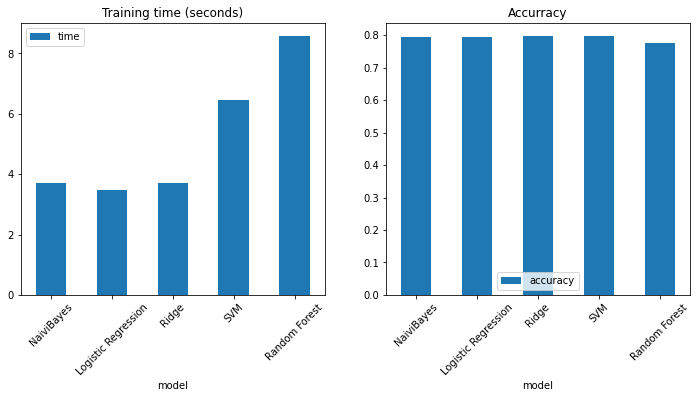

In [47]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

results_df[["model", "time"]].plot(kind="bar", x="model", y="time", rot=45, title="Training time (seconds)", ax=ax1)
results_df[["model", "accuracy"]].plot(kind="bar", x="model", y="accuracy", rot=45, title="Accurracy", ax=ax2)

### Use Grid Search for find the best model parameters

In [30]:
def grid_search(model, param_grid, x_train, y_train, x_test, y_test, target_names, cv=5, verbose=2):
    
    clf = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=verbose, n_jobs=-1)
    
    best_clf = clf.fit(x_train, y_train)
    y_true, y_pred = y_test, best_clf.predict(x_test)
    
    print(f"The best params for the model are {print(best_clf.best_params_)}")
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(f"Accuracy: {accuracy_score(y_pred, y_test)}")
    
    return best_clf

In [78]:
pipeline_vectorized = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v2)),
    ("tfidf", TfidfTransformer()),
])

x = pipeline_vectorized.fit_transform(train_df["text"])
y = train_df["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

### Grid Search for Logistic Regression

In [79]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['liblinear', 'sag', 'saga']}
]

_ = grid_search(LogisticRegression(), param_grid, x_train, y_train, x_test, y_test, target_names)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:   41.6s


{'C': 4.281332398719396, 'penalty': 'l2', 'solver': 'saga'}
The best params for the model are None
                   precision    recall  f1-score   support

Not real disaster       0.76      0.91      0.83      1275
    Real disaster       0.85      0.64      0.73      1009

         accuracy                           0.79      2284
        macro avg       0.80      0.77      0.78      2284
     weighted avg       0.80      0.79      0.78      2284

Accuracy: 0.7902802101576182


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.0min finished


### Grid Search for SVM

In [ ]:
c_list = [0.1, 1, 10, 100, 1000, 10000]
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 'scale', 'auto'], 'C': c_list},
              {'kernel': ['linear'], 'C': c_list},
              {'kernel': ['poly'], 'C': c_list, 'degree': [2, 3, 4]},
              {'kernel': ['sigmoid'], 'C': c_list}]

_ = grid_search(SVC(), param_grid, x_train, y_train, x_test, y_test, target_names)

### Grid Search for Random Forest

In [34]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 25, 50, 80, 90],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 80, 90, 100, 200, 300, 500]
}

_ = grid_search(RandomForestClassifier(), param_grid, x_train, y_train, x_test, y_test, target_names)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  6.0min finished


{'bootstrap': True, 'max_depth': 90, 'n_estimators': 50}
The best params for the model are None
                   precision    recall  f1-score   support

Not real disaster       0.76      0.93      0.83      1318
    Real disaster       0.86      0.59      0.70       966

         accuracy                           0.79      2284
        macro avg       0.81      0.76      0.77      2284
     weighted avg       0.80      0.79      0.78      2284

Accuracy: 0.7859019264448336


In [127]:
pipeline_vectorized = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v2)),
    ("tfidf", TfidfTransformer()),
])

x = pipeline_vectorized.fit_transform(train_df["text"])
y = train_df["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [125]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.15)

pipeline_svm = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning_v2)),
    ("tfidf", TfidfTransformer()),
    ("classifier", SVC(C=1000, gamma="scale", kernel="rbf")) # C=1000, gamma="scale", kernel="rbf" | {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
])

_ = train_and_predict_pipeline(pipeline_svm, x_train, y_train, x_test, y_test, target_names)


Training model ...
Done!
Training time: 4.6475249380000605
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.89      0.78      0.83       746
    Real disaster       0.67      0.81      0.73       396

         accuracy                           0.79      1142
        macro avg       0.78      0.80      0.78      1142
     weighted avg       0.81      0.79      0.80      1142

Confusion matrix:
[[585 161]
 [ 74 322]]

Accuracy: 0.7942206654991243
--------------------


In [101]:
pipeline_svm.fit(train_df["text"], train_df["target"])

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer=<function text_cleaning at 0x123bc6e50>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=

In [ ]:
# Try with best method to clean text
use tweet special text processor

#### Prediction and generate kaggle submission

In [102]:
y_pred = pipeline_svm.predict(test_df["text"])

In [103]:
def create_submission_file(predictions, ids, path, filename="submission.csv"):
    submission_data = {
        "id": ids,
        "target": predictions
    }

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(os.path.join(path, filename), index=False)
    
    print("Good luck!")

In [99]:
create_submission_file(y_pred, test_df.id, submissions_folder)

Good luck!


In [134]:
# TODO: Lemmatization # Word2vec